# Train & Test 데이터 불러오기

각 년도별 DataFrame을 리스트에 append합니다.

리스트 인덱스별로

0: 2017년도 데이터   

1: 2018년도 데이터 

2: 2019년도 데이터 

3: 202년도 데이터 

입니다

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.seed = 42
DATA_PATH = "../data_0119/"

warnings.filterwarnings(action='ignore')
PATH_2017 = DATA_PATH + "train/KNOW_2017.csv"
PATH_2018 = DATA_PATH + "train/KNOW_2018.csv"
PATH_2019 = DATA_PATH + "train/KNOW_2019.csv"
PATH_2020 = DATA_PATH + "train/KNOW_2020.csv"

paths = [PATH_2017, PATH_2018, PATH_2019, PATH_2020]
know_train = [pd.read_csv(path) for path in paths]

TEST_PATH_2017 = DATA_PATH + "test/KNOW_2017_test.csv"
TEST_PATH_2018 = DATA_PATH + "test/KNOW_2018_test.csv"
TEST_PATH_2019 = DATA_PATH + "test/KNOW_2019_test.csv"
TEST_PATH_2020 = DATA_PATH + "test/KNOW_2020_test.csv"

TEST_PATHs = [TEST_PATH_2017, TEST_PATH_2018, TEST_PATH_2019, TEST_PATH_2020]
know_test = [pd.read_csv(path) for path in TEST_PATHs]

In [2]:
know_train[3]

,idx,saq1_1,saq1_2,saq2_1,saq2_2,saq3_1,saq3_2,saq4_1,saq4_2,saq5_1,...,기계,건축,연구,방법,기술사,구조,기기,향상,ubda_cnt,knowcode
0,27127,4,4,4,4,4,5,4,5,3,...,0,0,0,0,0,0,0,0,0,304003
1,27128,5,6,5,6,4,5,4,5,4,...,0,0,0,0,0,0,0,0,0,221401
2,27129,3,4,3,4,3,4,3,5,3,...,0,0,0,0,0,0,0,0,0,815001
3,27130,4,5,2,3,3,3,4,5,3,...,0,0,0,0,0,0,0,0,0,304003
4,27131,5,6,4,5,3,5,4,4,4,...,0,0,0,0,0,0,0,0,0,140201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8117,35244,4,6,3,5,3,3,1,0,5,...,0,0,0,0,0,0,0,0,0,121105
8118,35245,3,4,4,5,2,4,4,6,1,...,0,0,0,0,0,0,0,0,0,26102
8119,35246,5,6,3,4,3,4,4,5,5,...,0,0,0,0,0,0,0,0,0,31301
8120,35247,5,6,5,5,4,5,3,3,3,...,0,0,0,0,0,0,0,0,0,154105


# 전처리 

`data_0119`는 이미 전처리된 데이터

In [3]:
years = ['2017', '2018', '2019', '2020']
for i in range(4):
    print(f"{2017+i}: {know_train[i].shape}")

2017: (9486, 271)
2018: (9072, 241)
2019: (8555, 251)
2020: (8122, 290)


## 라벨 인코딩

숫자로 변환할 수 있는 컬럼은 라벨 인코딩을 사용하지 않았습니다.

string이나 object컬럼은 라벨인코더를 이용해 변환하였으며 추후 test셋에 사용해야하기 때문에 년도별, 컬럼별로 dictionary를 이용해 저장하였습니다

In [4]:
from sklearn.preprocessing import LabelEncoder
years = ['2017', '2018', '2019', '2020']

year_encoder = {}

for year, df in zip(years, know_train):
    print(year)
    encoders = {}
    
    for col in df.columns:
        if col == 'idx':
            print("HEHE")
            continue
        
        try:
            df[col] = df[col].map(int)
        except:
            encoder = LabelEncoder()
            df[col] = df[col].map(str)
            df[col] = encoder.fit_transform(df[col])
            encoders[col] = encoder
            
            
    year_encoder[year] = encoders

2017
HEHE
2018
HEHE
2019
HEHE
2020
HEHE


In [5]:
# encode test data
years = ['2017', '2018', '2019', '2020']

for year, df in zip(years, know_test):
    print(year)
    encoders = {}
    
    for col in df.columns:
        
        try:
            df[col] = df[col].map(int)
        except:
            encoder = year_encoder[year][col]
            df[col] = df[col].map(str)
            category_map = {category: idx for idx, category in enumerate(encoder.classes_)}
            df[col] = df[col].apply(lambda x: category_map[x] if x in category_map else -1) # train set에서 보지못한 카테고리변수 -1(UNK) 처리
            

2017
2018
2019
2020


# X, y 구분 및 모델 학습

이번 대회에서 맞춰야 할 값은 knowcode입니다.

ID와 knowcode를 제외한 나머지 feature를 X, knowcode를 정답 y로 두어 모델을 학습하였습니다.

베이스라인에서는 의사결정나무와 랜덤포레스트를 선정하였습니다

df.drop(['idx','knowcode', 'description'], axis=1)

In [6]:
train_data = {}
for year, df in zip(years, know_train):
    train_data[year] = {'X': df.drop(['idx','knowcode','description'], axis=1),
                        'y': df['knowcode']}

test_data = {}
for year, df in zip(years, know_test):
    print(year)
    train_columns = train_data[year]['X'].columns
    test_data[year] =  {'X': df[train_columns]} 

2017
2018
2019
2020


In [7]:
for year in years:
    print(year)
    print(f"train: {train_data[year]['X'].shape} test: {test_data[year]['X'].shape}")

2017
train: (9486, 268) test: (9486, 268)
2018
train: (9072, 238) test: (9069, 238)
2019
train: (8555, 248) test: (8554, 248)
2020
train: (8122, 287) test: (8122, 287)


## Oversample
class 불균형 반영한 Oversampling

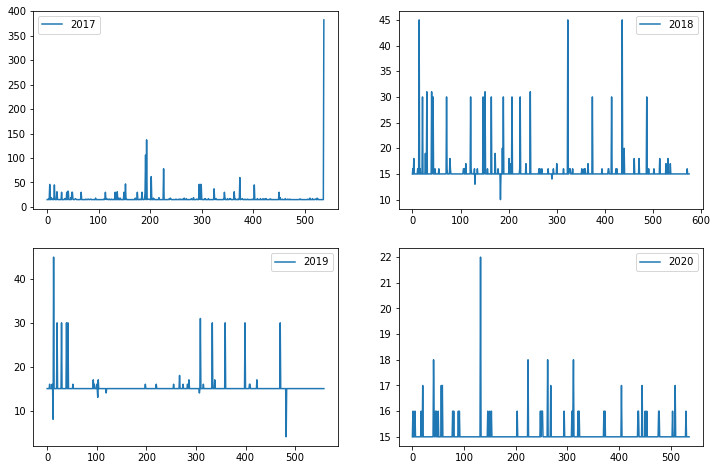

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for year in years:
    if year == '2017': r,c = 0,0
    elif year == '2018': r,c = 0,1
    elif year == '2019': r,c = 1,0
    elif year == '2020': r,c = 1,1
    
    d = train_data[year]['y'].value_counts().sort_index().tolist()
    axes[r, c].plot(d, label=f"{year}")
    axes[r, c].legend()

fig.show()

In [9]:
for year in years:
    print(year)
    print(f"X :{train_data[year]['X'].shape}, y: {train_data[year]['y'].shape}")

2017
X :(9486, 268), y: (9486,)
2018
X :(9072, 238), y: (9072,)
2019
X :(8555, 248), y: (8555,)
2020
X :(8122, 287), y: (8122,)


In [25]:
# resampling with numpy
train_data_resampled = {}
np.random.seed(RANDOM_STATE)

for year in years:
    print(f"{year} sampling")
    data_size = len(train_data[year]['y'])
    ids = np.arange(data_size)
    choices = np.random.choice(ids, int(2.5*data_size))
    X_resampled = train_data[year]['X'].iloc[choices]
    y_resampled = train_data[year]['y'].iloc[choices]
    
    train_data_resampled[year] = {
        'X': X_resampled, 'y': y_resampled
    }
    print("done")

2017 sampling
done
2018 sampling
done
2019 sampling
done
2020 sampling
done


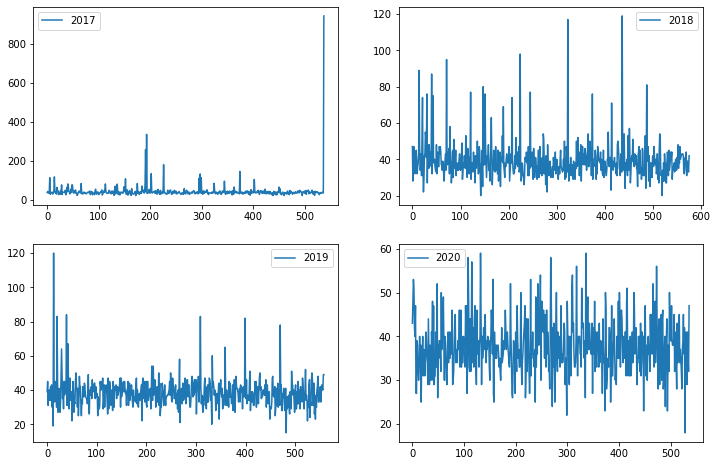

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for year in years:
    if year == '2017': r,c = 0,0
    elif year == '2018': r,c = 0,1
    elif year == '2019': r,c = 1,0
    elif year == '2020': r,c = 1,1
    
    d = train_data_resampled[year]['y'].value_counts().sort_index().tolist()
    axes[r, c].plot(d, label=f"{year}")
    axes[r, c].legend()

fig.show()

In [27]:
for year in years:
    print(year)
    print(
        f"X :{train_data[year]['X'].shape}, y: {train_data[year]['y'].shape} -> X :{train_data_resampled[year]['X'].shape}, y: {train_data_resampled[year]['y'].shape}")

2017
X :(9486, 268), y: (9486,) -> X :(23715, 268), y: (23715,)
2018
X :(9072, 238), y: (9072,) -> X :(22680, 238), y: (22680,)
2019
X :(8555, 248), y: (8555,) -> X :(21387, 248), y: (21387,)
2020
X :(8122, 287), y: (8122,) -> X :(20305, 287), y: (20305,)


In [28]:
# compare distribution by std

for year in years:
    dist_dic = {}
    for c in train_data[year]['y']:
        if c not in dist_dic.keys():
            dist_dic[c] = 1
        else:
            dist_dic[c] += 1
    
    dist_dic_res = {}
    for c in train_data_resampled[year]['y']:
        if c not in dist_dic_res.keys():
            dist_dic_res[c] = 1
        else:
            dist_dic_res[c] += 1
    
    o_max = max(dist_dic.values())
    o_list = [v/o_max for v in dist_dic.values()]

    r_max = max(dist_dic_res.values())
    r_list = [v/r_max for v in dist_dic_res.values()]
    print(f"{year}: original std = {np.std(o_list):.3f}, resampled std = {np.std(r_list):.3f}")


2017: original std = 0.047, resampled std = 0.047
2018: original std = 0.075, resampled std = 0.089
2019: original std = 0.053, resampled std = 0.071
2020: original std = 0.023, resampled std = 0.109


# Extra Trees Classifier

`n_estimators = 500`

In [14]:
from sklearn.ensemble import ExtraTreesClassifier

et_models = {}
et_predicts = [] 

for year in tqdm(years):
    # train
    model = ExtraTreesClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=8)
    model.fit(train_data_resampled[year]['X'].iloc[:, :], train_data_resampled[year]['y'])

    # predict
    pred = model.predict(test_data[year]['X'])
    et_predicts.extend(pred)

100%|██████████| 4/4 [01:30<00:00, 22.56s/it]


# 제출

In [15]:
submission = pd.read_csv('../data_0103/sample_submission.csv') # sample submission 불러오기

In [16]:
submission['knowcode'] = et_predicts

submission.to_csv('../submission_files/et_500_oversample_with_data_0119.csv', index=False)